In [1]:
#Aalysis of outputs with SSH, SST (unfiltered), and (u,v) as inputs. 
#Include: snapshot plots, power spectra. Different methods for computing power spectra are experimented on.
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import KFold
from copy import deepcopy
from scipy.stats import pearsonr
from pathlib import Path
import numpy.fft as fft
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import colorcet as cc


vel_cmap  = cc.cm.CET_CBD1
TOTssh_cmap =  cc.cm.CET_D2
ITssh_cmap  = cc.cm.CET_D1A
sst_cmap = cc.cm.linear_bmy_10_95_c78
vort_cmap =  cc.cm.CET_D3

bottom_slice = slice(0,256)
mid_slice = slice(232, 488)
top_slice = slice(464, 720)

def corr(data, mod):
    return pearsonr(data.flatten(), mod.flatten())[0]
def L2_R(data,mod):
    return R2(data.flatten(), mod.flatten())
def performance_metrics(data, mod):
    return corr(data, mod), L2_R(data,mod)

modeloutput_dir = '../model_outputs/'
npfile_OUNet = np.load(modeloutput_dir+'HUTcombs_UNet.npz')
npfile_2lUNet = np.load(modeloutput_dir+'outputs_TwoLayerUNet.npz')


snap_index = 100
colorlist=['#DDAA33','#004488','#BB5566']
figfolder = '../hwfigures/'
iplotend = 90

In [2]:
H_out_OUNet = npfile_OUNet['arr_1']

H_out_2lUNet = npfile_2lUNet['arr_0'] #In the production code, np.savez(modeloutput_dir+'outputs_TwoLayerUNet', H_out_mod, U_out_mod, HT_out_mod, out_test) 

Truth_test = npfile_OUNet['arr_7']

In [3]:
nt, _, ny, nx= np.shape(H_out_OUNet)

dx = 4000 #Grid resolution is 4 km
Lx = nx*dx
Ly = ny*dx
print (Ly)

#axes used for plotting only
x_axis = np.arange(0, Lx, dx)/1000 # in km
y_axis = np.arange(0, Ly, dx)/1000
extent = [np.min(x_axis), np.max(x_axis), np.min(y_axis), np.max(y_axis)]

2880000


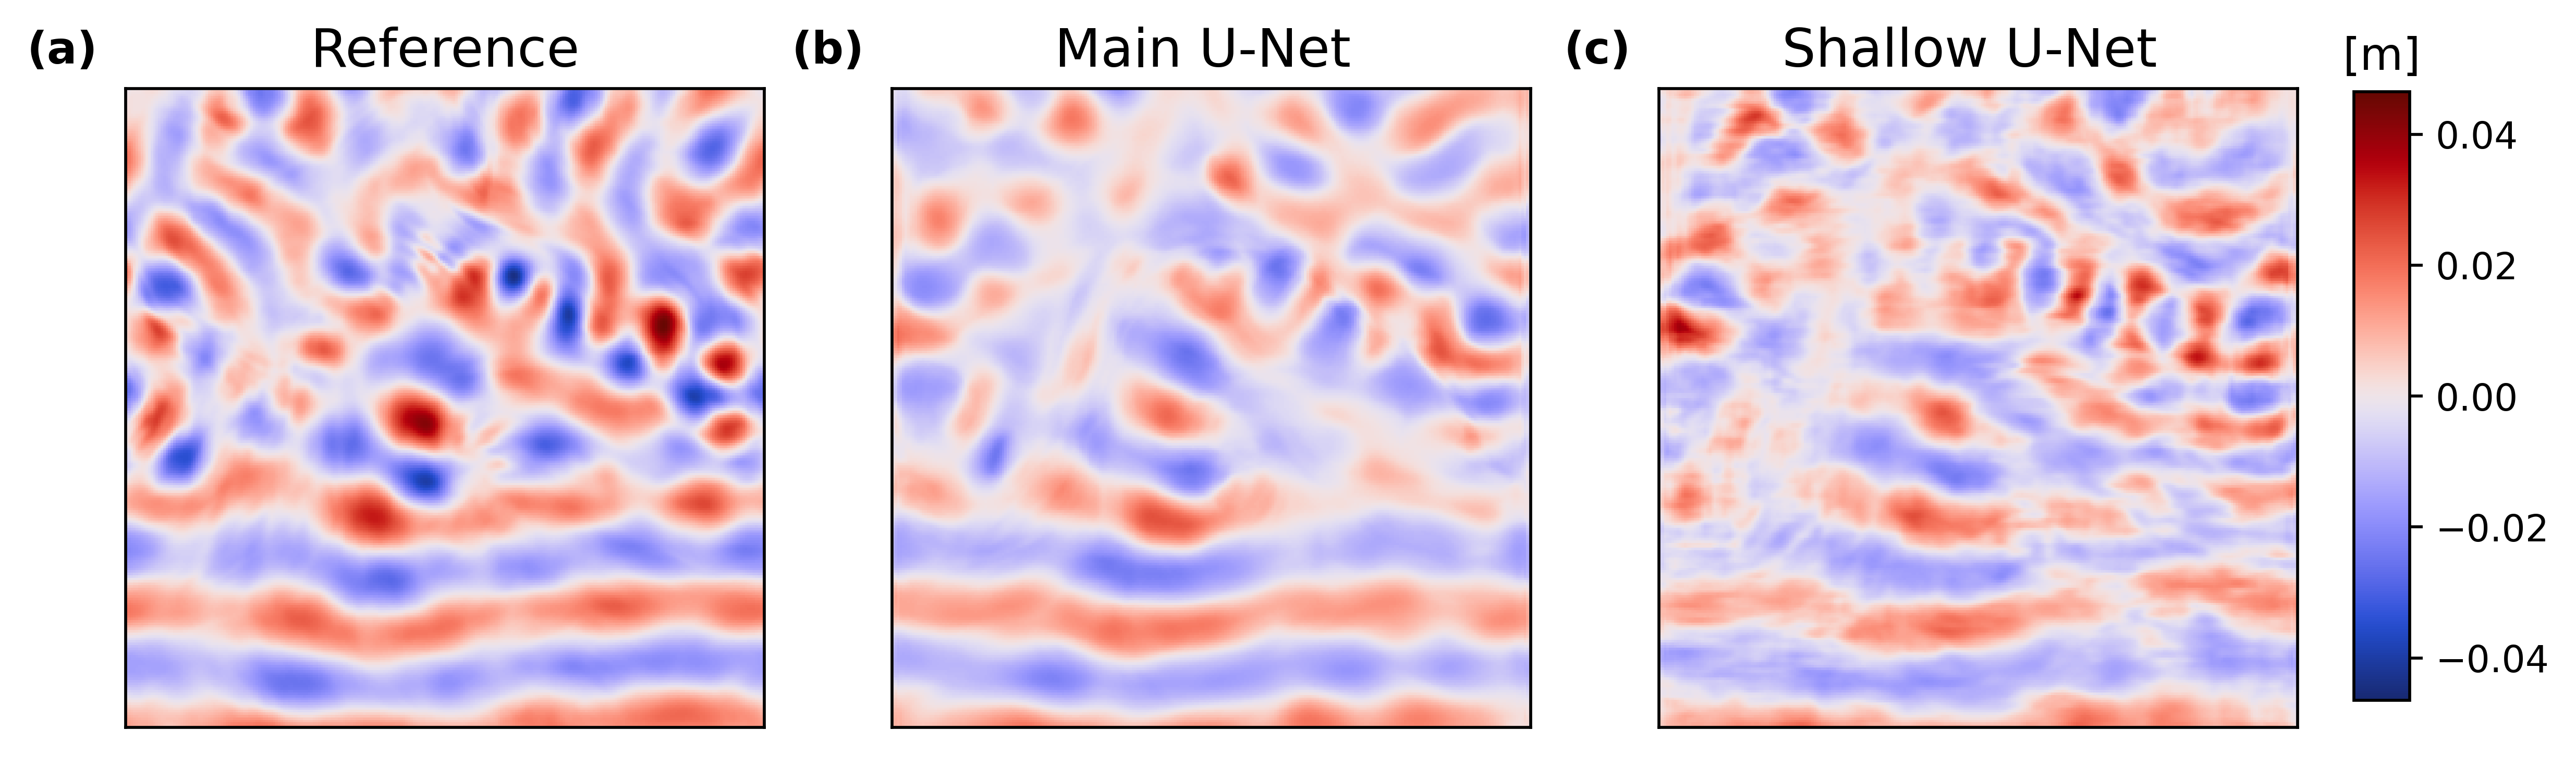

In [4]:
all_outputs = [H_out_OUNet, H_out_2lUNet]
outputs_cosssh_HUTcomb =  np.stack([array[:, 0, :, :] for array in all_outputs], axis=0)
outputs_sinssh_HUTcomb =  np.stack([array[:, 1, :, :] for array in all_outputs], axis=0)


truth_snapshot = Truth_test[snap_index, 0]

ITm = np.max(np.abs(truth_snapshot))
ITclims = (-ITm, ITm)

model_ordering = [r'Main U-Net',r'Shallow U-Net']
fig=plt.figure(figsize = (10.5,6))
fig.set_dpi(512)
axes_list = []
for i in range(2):
    plt.subplot(1, 3,i+2)
    ax = plt.subplot(1, 3, i+2)  
    axes_list.append(ax)
    plt.imshow(outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :], origin ='lower', cmap = ITssh_cmap, clim =ITclims)
#     correlation = corr(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
#     coeff_determ = L2_R(truth_snapshot[mid_slice, :], outputs_cosssh_HUTcomb[i,snap_index, mid_slice, :])
#     print (correlation)
# #     plt.text(40, 20, r'$\mathcal{\Upsilon}$ = ' +  str(round(correlation, 2)), fontsize = 'x-large')
# #     plt.text(40, 60, r'$R_2$ = ' +  str(round(coeff_determ, 2)), fontsize = 'x-large')
#     plt.xlabel(r'$\mathcal{\Upsilon}/R_2 = $'+ str(round(correlation, 2))+'/'+str(round(coeff_determ, 2)),
#                fontsize = 'x-large')
    plt.xticks([])
    plt.yticks([])

    plt.title('{} '.format(model_ordering[i]), fontsize = 'x-large')
plt.subplot(1, 3,1)
im = plt.imshow(truth_snapshot[mid_slice, :] , origin ='lower', cmap = ITssh_cmap, clim =ITclims)
#plt.colorbar()
plt.title('Reference',  fontsize = 'x-large')
plt.xticks([])
plt.yticks([])
ax = plt.subplot(1,3, 1)
axes_list.insert(0, ax)  # So that it's the first panel

# Create a single colorbar for the figure
cbar_ax = fig.add_axes([0.92, 0.32, 0.02, 0.38])
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.set_label('[m]', fontsize='x-large')  # Add title to the colorbar
cbar.ax.set_title('[m]', fontsize='large', pad=6)

labels = ['(a)', '(b)', '(c)']  
for i, ax in enumerate(axes_list):
    pos = ax.get_position()
    x = pos.x0
    y = pos.y1
    fig.text(x - 0.01, y + 0.01, labels[i], fontsize='large', fontweight='bold', va='bottom', ha='right')
    

fig.savefig(figfolder+'shallowUNet_performance.png', bbox_inches='tight',dpi=512)